In [7]:
import os
import ee
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

import geemap

from geeml.utils import eeprint


Successfully saved authorization token.


In [4]:
import ee
service_account = 'github-action@ee-geethensingh.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, r"C:\Users\coach\myfiles\postdoc\Fire\code\secret.json")
ee.Initialize(credentials)

In [7]:
os.chdir(r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src")
os.getcwd()

'C:\\Users\\coach\\myfiles\\postdoc\\Fire\\code\\Burn_Area_Mapping\\src'

In [9]:
from components.data_extraction import extractDataset
%load_ext autoreload

ModuleNotFoundError: No module named 'exception'

In [4]:
%autoreload 2

In [6]:
Map = geemap.Map()
fc = ee.FeatureCollection("projects/ee-geethensingh/assets/postdoc/proj_fired_south_africa_to2021182_events")
Map.addLayer(ee.Feature(fc.first()), {'color': 'red'}, "Fire Test")
Map.centerObject(fc.first(), 12)
Map

Map(center=[-31.374999751707104, 29.510986261502627], controls=(WidgetControl(options=['position', 'transparen…

## Step 1: Data extraction

In [7]:
# Filter fire events to period and area of interest
fireEvents = fc.map(lambda ft: ft.set('system:time_start', ee.Date(ft.get('ig_date')))
                    .set('system:time_end', ee.Date(ft.get('last_date')))).filterDate('2019-01-01', '2020-01-01')

In [8]:
# Get Landsat-8 features for South Africa
extractDataset('LANDSAT_8', 'South Africa', ee.Date('2019-09-01'), ee.Date('2020-01-01'), fireEvents, 16, 'extract_20190912.csv')

  0%|          | 0/572 [00:00<?, ?it/s]

## Step 2: train and evaluation

In [7]:
from data_ingestion import dataIngestion
from data_transformation import dataTransformation
from model_trainer import modelTrainer

Naive Baseline Accuracy: 0.74
No best model found, metric < 0.6


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached 'artifacts'
            git commit -m "stop tracking artifacts" 


classification report               precision    recall  f1-score   support

         0.0       0.79      0.93      0.86       206
         1.0       0.59      0.28      0.38        71

    accuracy                           0.77       277
   macro avg       0.69      0.61      0.62       277
weighted avg       0.74      0.77      0.73       277

Confusion Matrix:


0.380952380952381

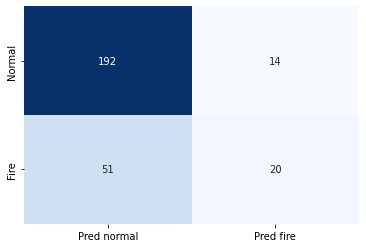

In [8]:
obj = dataIngestion()
train_path, calibration_path, test_path = obj.initiate_data_ingestion()
data_transformation = dataTransformation()
train_arr, cal_arr, test_arr = data_transformation.initiate_data_transformation(train_path, calibration_path, test_path)

model_trainer = modelTrainer()
model_trainer.initiate_model_trainer(train_arr, cal_arr, test_arr)

## Step 3: Inference

In [21]:
from src.utils import load_object
import pandas as pd

from mapie.classification import MapieClassifier

# model = load_object(r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\model.pkl")
df = pd.read_csv(r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\train.csv")


X_train = df.drop(['scenes', 'label'], axis=1)
y_train = df[['label']]

# from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state= 42, verbose= False).fit(X_train, y_train)
print(model.predict(dfPredict))

mapie_score = MapieClassifier(estimator = model, cv="prefit", method="lac", random_state= 42)
mapie_score.fit(X_train, y_train)
mapie_score.predict(dfPredict, alpha =0.05)

[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0
 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]


(array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 array([[[ True],
         [False]],
 
        [[F

In [25]:
from inference import Inference

inference_pipeline = Inference()
sceneList = inference_pipeline.initiate_inference_pipeline('LANDSAT_8', 'South Africa')
sceneList

Number of new scenes: 55
input dates 2024-03-01 2024-04-02


  0%|          | 0/55 [00:00<?, ?it/s]

0    2_LC08_160092_20240310
0    2_LC08_167079_20240311
0    2_LC08_167080_20240311
0    2_LC08_168077_20240302
0    2_LC08_168078_20240302
0    2_LC08_168080_20240302
0    2_LC08_168081_20240302
0    2_LC08_168082_20240302
0    2_LC08_169075_20240309
0    2_LC08_169078_20240309
0    2_LC08_169079_20240309
0    2_LC08_169080_20240309
0    2_LC08_169082_20240309
0    2_LC08_171076_20240307
0    2_LC08_171078_20240307
0    2_LC08_171079_20240307
0    2_LC08_171080_20240307
0    2_LC08_171081_20240307
0    2_LC08_171082_20240307
0    2_LC08_173077_20240305
0    2_LC08_173078_20240305
0    2_LC08_173079_20240305
0    2_LC08_173080_20240305
0    2_LC08_173081_20240305
0    2_LC08_173082_20240305
0    2_LC08_175077_20240303
0    2_LC08_175078_20240303
0    2_LC08_175082_20240303
0    2_LC08_176077_20240310
0    2_LC08_176078_20240310
0    2_LC08_177081_20240301
Name: scenes, dtype: object

In [43]:
# Example usage:
# Delete logs older than March 1, 2024
delete_old_logs(r'C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping', datetime.datetime(2024, 3, 11))
# Or, delete logs older than one month (default behavior)
delete_old_logs(r'C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping')

Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_06_2024_14_13_35.log\03_06_2024_14_13_35.log
Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_06_2024_23_25_28.log\03_06_2024_23_25_28.log
Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_07_2024_09_11_34.log\03_07_2024_09_11_34.log
Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_07_2024_20_08_47.log\03_07_2024_20_08_47.log
Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_08_2024_09_41_30.log\03_08_2024_09_41_30.log
Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_08_2024_10_15_57.log\03_08_2024_10_15_57.log
Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_08_2024_10_19_03.log\03_08_2024_10_19_03.log
Deleted file:

## Stage 2: Semantic Segmentation

In [40]:
import os
os.getcwd()
os.chdir("C:/Users/coach/myfiles/postdoc/Fire/code/Burn_Area_Mapping/src")

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
os.getcwd()

'C:\\Users\\coach\\myfiles\\postdoc\\Fire\\code\\Burn_Area_Mapping\\src'

In [ ]:
%autoreload 2
from stage_2.inference import segment

segment().main()

In [45]:
# check which scenes need to be downloaded
from src.utils import load_object
import ee
from geeml.utils import eeprint
from geedim.download import BaseImage
import torch
import segmentation_models_pytorch as smp
# ee.Authenticate()
ee.Initialize()

supportedSensors = {'Sentinel-1': ee.ImageCollection('COPERNICUS/S1_GRD'),
                    'Sentinel-2': ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED"),
                    'LANDSAT_8': ee.ImageCollection("LANDSAT/LC08/C02/T1_L2"),
                    'LANDSAT_9': ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")}

def preprocessOptical(image, sensor):
    bandSelect = {'Sentinel-2': 'B.*',
                    'LANDSAT_8': 'SR_B.',
                    'LANDSAT_9': 'SR_B.'}
    # Step 2) radiometric correction
    radiometricMultiplySelect = {'Sentinel-2': 0.0001,
                    'LANDSAT_8': 0.0000275,
                    'LANDSAT_9': 0.0000275}
    radiometricAddSelect = {'Sentinel-2': 0,
                    'LANDSAT_8': -0.2,
                    'LANDSAT_9': -0.2}
    
    # Step 3) depending on image selected, select cloud band
    return image.select(bandSelect.get(sensor)).multiply(radiometricMultiplySelect.get(sensor)).add(radiometricAddSelect.get(sensor))
    
def downloadInferenceInstance(imageID: str)-> ee.Image:
    """Given an Image ID that is predicted (by the scene classification model) to contain a burn area,
    download the required input data for the semantic segmentation model
    
    Args:
        imageID (str): earth engine image ID
        
    Returns:
        ee.Image with 16 bands for the before and after image
        
        """
    eventImage = ee.Image.load(f'LANDSAT/LC08/C02/T1_L2/{imageID}')
    postImg = preprocessOptical(eventImage, 'LANDSAT_8').regexpRename('$', '_post')
    eventDate = eventImage.date()
    startDate = eventDate.advance(5*-1, 'week')
    endDate = eventDate
    images = supportedSensors.get('LANDSAT_8').filterBounds(postImg.geometry())
    preImg = preprocessOptical(ee.Image(images.filterDate(startDate, endDate)\
        .sort('system:time_start', False).first()), 'LANDSAT_8').regexpRename('$', '_pre')
    return preImg.addBands(postImg)
    
downloadList = load_object(r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\downloadList.pkl")
downloadList
# load image
for img in downloadList[20:21]:
    print(img[2:])
    # download scenes
    eeImg = downloadInferenceInstance(img[2:])
    filename = f'C:/Users/coach/myfiles/postdoc/Fire/code/Burn_Area_Mapping/src/components/artifacts/segScenes/{img[2:]}.tif'
    BaseImage(eeImg).download(filename, crs='EPSG:4326', region= eeImg.geometry(), scale=30, overwrite=True, num_threads=20, dtype= 'float64')
    #load model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = smp.Unet(
        encoder_name="resnet34",        
        encoder_weights= None,     
        in_channels=16,                  
        classes=2,  
    ).to(device)
    # r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
    checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\UNet_05072024.pth")
    model.load_state_dict(checkpoint)
    
    # run inference
    # 5min13s to download and 1min to run inference
    # upload to gee imagecollection

LC08_173078_20240305


LC08_173078_20240305.tif: |          | 0.00/7.18G (raw) [  0.0%] in 00:00 (eta:     ?)

There is no STAC entry for: None


In [14]:
import geemap
Map = geemap.Map()
img = "2_LC08_173078_20240305"
eeimg = ee.Image.load(f'LANDSAT/LC08/C02/T1_TOA/{img[2:]}').select(["B7","B5","B4"])
Map.addLayer(eeimg, {'bands': ['B7', 'B5', 'B4'], 'min':0, 'max':0.7})
Map.centerObject(eeimg.geometry(), 9)
Map

Map(center=[-25.995204899918985, 23.860780416242243], controls=(WidgetControl(options=['position', 'transparen…

In [ ]:
import rasterio as rio
from rasterio import windows
import matplotlib.pyplot as plt

# Define the path to the raster file
raster_path = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\Y\label_0.tif"

def overlapping_blocks(src, overlap=0, band=1, patch_size=64):
    profile = src.profile
    profile.update(blockxsize= patch_size, blockysize= patch_size, tiled=True, count=1)

    for ji, window in src.block_windows(1):
        # Adjust the window to include the overlap
        col_off = max(window.col_off - overlap, 0)
        print(window.col_off)
        row_off = max(window.row_off - overlap, 0)
        width = min(patch_size + overlap * 2, src.width - col_off)
        height = min(patch_size + overlap * 2, src.height - row_off)
        
        window = windows.Window(
            col_off=col_off,
            row_off=row_off,
            width=width,
            height=height
        )
        print(window)
        yield window

# Function to plot the window
def plot_window(data):
    plt.figure(figsize=(6, 6))
    plt.imshow(data, cmap='gray')
    plt.axis('off')
    plt.show()

def process_image(src_img, band_id=1):
    with rio.open(src_img) as src:
        for window in overlapping_blocks(src, overlap=32, patch_size=256):
            src_data = src.read(band_id, window=window)
            print(f'Window shape: {src_data.shape}, Window location: {window}')
            plot_window(src_data)

process_image(raster_path)


In [17]:
import os
os.chdir('c:\\Users\\coach\\myfiles\\postdoc\\Fire\\code\\Burn_Area_Mapping\\src')
os.getcwd()

'c:\\Users\\coach\\myfiles\\postdoc\\Fire\\code\\Burn_Area_Mapping\\src'

In [22]:
from src.utils import load_object
from utils import MyNormalize
from torchgeo.transforms import indices, AugmentationSequential

# mean, std = load_object(r"components\artifacts\norm_vals.pkl")
# normalize = MyNormalize(mean=mean, stdev=std)

# Create transforms
data_transform = AugmentationSequential(
    indices.AppendNDWI(index_green=2, index_nir=4),
    indices.AppendNDVI(index_nir=4, index_red=3),
    data_keys = ["image"]
)

In [53]:
import logging
import os
import math
from pathlib import Path
from typing import Callable, Optional

import rasterio as rio
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.auto import tqdm
from rasterio.windows import Window

import os
import ee
import threading

def inference(
    infile: str,
    imgTransforms: Callable[[dict], dict],
    model: torch.nn.Module,
    outfile: str,
    patchSize: int,
    overlap: int = 16,
    num_workers: int = 4,
    device: Optional[str] = None
) -> None:
    """
    Run inference using model on infile block-by-block and write to a new file (outfile).
    If the infile image width/height is not exactly divisible by 32, padding
    is added for inference and removed prior to saving the outfile.
    
    Args:
        infile (str): Path to input image/covariates.
        imgTransforms (Callable): Function to transform input images.
        model (torch.nn.Module): Loaded trained model/checkpoint.
        outfile (str): Path to save the predicted image.
        patchSize (int): Must be a multiple of 32. Size independent of model input size.
        overlap (int): Number of overlapping pixels between patches.
        num_workers (int): Number of workers to parallelize across.
        device (str, optional): Device to run the model on.
        
    Returns:
        None: A TIFF file is saved to the outfile destination.

    # Example usage:
        # infile = 'path/to/input.tif'
        # imgTransforms = some_torchgeo_transforms_function
        # model = some_loaded_pytorch_model
        # outfile = 'path/to/output.tif'
        # inference(infile, imgTransforms, model, outfile, patchSize=256, overlap=16, num_workers=4, device='cuda')
    """
    
    # Open the input file using rasterio
    with rio.open(infile) as src:
        # Set up logging
        logger = logging.getLogger(__name__)
        
        # Create a destination dataset based on source parameters
        profile = src.profile
        profile.update(blockxsize=patchSize, blockysize=patchSize, tiled=True, count=1)
        
        # Open the output file with the updated profile
        with rio.open(Path(outfile), "w", **profile) as dst:
            # Get all windows (patches) in the destination dataset
            windows = [window for ij, window in dst.block_windows()]
            
            # Create locks for reading and writing to ensure thread safety
            read_lock = threading.Lock()
            write_lock = threading.Lock()
            
            def process(window: Window) -> None:
                """
                Process a single window (patch) by reading it, transforming it, running the model on it,
                and writing the result to the output file.
                """
                # Acquire the read lock to safely read from the input file
                with read_lock:
                    col_off = max(window.col_off - overlap, 0)
                    row_off = max(window.row_off - overlap, 0)
                    
                    # Adjust width and height based on overlap and boundaries
                    if col_off == 0 or row_off == 0:
                        width = min(patchSize + overlap, src.width - col_off)
                        height = min(patchSize + overlap, src.height - row_off)
                    else:
                        width = min(patchSize + overlap * 2, src.width - col_off)
                        height = min(patchSize + overlap * 2, src.height - row_off)
                    
                    # Create a window with overlap
                    overlap_window = Window(
                        col_off=col_off,
                        row_off=row_off,
                        width=width,
                        height=height
                    )
                    
                    # Read the data from the input file within the overlap window
                    src_array = src.read(window=overlap_window)
                    
                    # Add padding if the patch is on the boundary of the large image
                    if col_off == 0 or row_off == 0:
                        pad_left = overlap if col_off == 0 else 0
                        pad_top = overlap if row_off == 0 else 0
                        transform = transforms.Pad((pad_left, pad_top, 0, 0))
                        src_array = transform(torch.from_numpy(src_array))
                    else:
                        src_array = torch.from_numpy(src_array)
                    
                    # Get the width and height of the transformed source array
                    w, h = src_array.shape[1], src_array.shape[2]
                    
                    # Apply the image transformations
                    image = imgTransforms({"image": src_array})['image']
                    image = image.to(device, dtype=torch.float)
                    
                    # Set the model to evaluation mode
                    model.eval()
                    
                    # Pad the image if its dimensions are not divisible by patchSize + overlap * 2
                    if w % (patchSize + overlap * 2) != 0 or h % (patchSize + overlap * 2) != 0:
                        hpad = math.ceil(h / (patchSize + overlap * 2)) * (patchSize + overlap * 2) - h
                        wpad = math.ceil(w / (patchSize + overlap * 2)) * (patchSize + overlap * 2) - w
                        transform = transforms.Pad((0, 0, hpad, wpad))
                        image = transform(image)
                        
                        # Run the model on the padded image
                        output = model(image)[:, 1, :, :].squeeze()
                        
                        # Remove padding from the output
                        result = output[overlap:patchSize + overlap, overlap:patchSize + overlap].detach().cpu()
                    else:
                        # Run the model on the image
                        result = model(image)[:, 1, overlap:patchSize + overlap, overlap:patchSize + overlap].squeeze().detach().cpu()
                    
                # Acquire the write lock to safely write to the output file
                with write_lock:
                    dst.write(result.numpy(), 1, window=window)
            
            # Use a ThreadPoolExecutor to process the windows in parallel
            with tqdm(total=len(windows), desc=os.path.basename(outfile)) as pbar:
                with ThreadPoolExecutor(max_workers=num_workers) as executor:
                    futures = {executor.submit(process, window): window for window in windows}
                    
                    try:
                        for future in as_completed(futures):
                            future.result()  # Wait for the future to complete
                            pbar.update(1)  # Update the progress bar
                    except Exception as ex:
                        logger.error('Error during inference: %s', ex)
                        executor.shutdown(wait=False, cancel_futures=True)
                        raise ex


In [54]:
dd = r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segScenes\predictions\predScene.tif"
# filename2 = r"C:\Users\coach\myfiles\postdoc\Fire\data\indonesia\fire_data\images\L8_100066_010919_001.tif"
filename = r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segScenes\LC08_173078_20240305.tif"
inference(infile = filename, imgTransforms= data_transform, model = model, outfile = dd, patchSize = 512, overlap = 32, num_workers=1, device = device)

predScene.tif:   0%|          | 0/272 [00:00<?, ?it/s]